In [183]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from joblib import dump

# Kontext

https://ourworldindata.org/

In [184]:
# Load the data files
file_path_female = 'data/remaining-life-expectancy-at-different-ages-females.csv'
file_path_male = 'data/remaining-life-expectancy-at-different-ages-males.csv'

female_data = pd.read_csv(file_path_female)
male_data = pd.read_csv(file_path_male)

#### Create basic df structure with clear target variable of remaining-life-expectancy-at-different-ages-females and males

In [185]:
# Extracting age columns and reshaping the female data
female_reshaped = female_data.melt(id_vars=['Entity', 'Year', 'Code'],
                                   var_name='Age', value_name='Remaining Life Expectancy')
female_reshaped['Sex'] = 'Female'

# Extracting age columns and reshaping the male data, including 'Code'
male_reshaped = male_data.melt(id_vars=['Entity', 'Year', 'Code'],
                               var_name='Age', value_name='Remaining Life Expectancy')
male_reshaped['Sex'] = 'Male'

# Concatenate the reshaped dataframes with 'Code'
combined_data = pd.concat([female_reshaped, male_reshaped])

# Extract the age from the 'Age' column
combined_data['Age'] = combined_data['Age'].str.extract(r'Age: (\d+)').astype(int)

# Reordering columns for clarity
combined_data = combined_data[['Entity', 'Code', 'Year', 'Sex', 'Age', 'Remaining Life Expectancy']]

combined_data.head()

,Entity,Code,Year,Sex,Age,Remaining Life Expectancy
0,Afghanistan,AFG,1950,Female,0,28.3905
1,Afghanistan,AFG,1951,Female,0,28.6345
2,Afghanistan,AFG,1952,Female,0,29.1260
3,Afghanistan,AFG,1953,Female,0,29.6212
4,Afghanistan,AFG,1954,Female,0,29.9004


# Explorative Datenanalyse (EDA)

In [186]:
combined_data.shape

(278908, 6)

In [187]:
combined_data.describe()

,Year,Age,Remaining Life Expectancy
count,278908.000000,278908.000000,278908.000000
mean,1978.822658,34.285714,38.468101
std,32.813750,27.701077,22.017019
min,1751.000000,0.000000,1.846400
25%,1963.000000,10.000000,15.169150
50%,1983.000000,25.000000,42.852350
75%,2002.000000,65.000000,56.466300
max,2021.000000,80.000000,88.727200


# Unifying & Transformation

Based on an analysis of the available datasets, we have decided to limit the data range to the years 2000 to 2020. This will help us manage the amount of missing data (NaN) more effectively.

In [188]:
# Filtering the data for years between 2000 and 2020, removing rows without a 'Code' variable, and excluding the 'World'
filtered_data = combined_data.dropna(subset=['Code'])
filtered_data = filtered_data[(filtered_data['Year'] >= 2000) & (filtered_data['Year'] <= 2020) & (filtered_data['Entity'] != 'World')]

filtered_data.to_csv('filtered_data-2000_2020.csv', index=False)
filtered_data.head()


,Entity,Code,Year,Sex,Age,Remaining Life Expectancy
50,Afghanistan,AFG,2000,Female,0,56.8579
51,Afghanistan,AFG,2001,Female,0,57.3437
52,Afghanistan,AFG,2002,Female,0,57.6715
53,Afghanistan,AFG,2003,Female,0,58.6498
54,Afghanistan,AFG,2004,Female,0,59.2159


#### Adding more data

In [189]:
# Load the additional data files
file_path_education_expenditure = 'data/total-government-expenditure-on-education-gdp.csv'
file_path_internet_usage = 'data/share-of-individuals-using-the-internet.csv'
file_path_electricity_access = 'data/share-of-the-population-with-access-to-electricity.csv'
file_path_sanitation = 'data/share-using-safely-managed-sanitation.csv'
file_path_smoking = 'data/share-of-adults-who-smoke.csv'
file_path_gdp = 'data/gdp.csv'
file_path_meat_supply = 'data/meat-supply-per-person.csv'
file_path_obesity = 'data/obesity.csv'
file_path_healthcare_spending = 'data/public-healthcare-spending-share-gdp.csv'
file_path_air_pollution = 'data/pm25-air-pollution.csv'
file_path_democracy_index = 'data/DemocracyIndex.csv'

# Reading the data files into DataFrames
education_expenditure_data = pd.read_csv(file_path_education_expenditure)
internet_usage_data = pd.read_csv(file_path_internet_usage)
electricity_access_data = pd.read_csv(file_path_electricity_access)
sanitation_data = pd.read_csv(file_path_sanitation)
smoking_data = pd.read_csv(file_path_smoking)
gdp_data = pd.read_csv(file_path_gdp)
meat_supply_data = pd.read_csv(file_path_meat_supply)
obesity_data = pd.read_csv(file_path_obesity)
healthcare_spending_data = pd.read_csv(file_path_healthcare_spending)
air_pollution_data = pd.read_csv(file_path_air_pollution)

# Reading and selecting specific columns from the Democracy Index file
democracy_index_data = pd.read_csv(file_path_democracy_index)[['Entity', 'Code', 'Year', 'Electoral democracy index']]

# Joining all these dataframes with the filtered_data dataframe based on 'Entity' and 'Year'
# Only join when the year exists in the filtered_data
# Adding custom suffixes to handle duplicate column names
merged_data = filtered_data
for df in [education_expenditure_data, internet_usage_data, electricity_access_data, 
           sanitation_data, smoking_data, gdp_data, meat_supply_data, 
           obesity_data, healthcare_spending_data, air_pollution_data, democracy_index_data]:
    merged_data = merged_data.merge(df, on=['Entity', 'Year'], how='left', suffixes=('', '_extra'))

# Dropping extra columns created due to overlapping column names (if any)
columns_to_drop = [col for col in merged_data.columns if '_extra' in col]
merged_data.drop(columns=columns_to_drop, inplace=True)

merged_data.sample(10)

merged_data.to_csv('merged_data.csv', index=False)



##### checking if data is correctly merged

In [190]:
# Filter the DataFrame for Switzerland and the year 2010
switzerland_data_2010 = merged_data[(merged_data['Entity'] == 'Switzerland') & (merged_data['Year'] == 2010)]

switzerland_data_2010

,Entity,Code,Year,Sex,Age,Remaining Life Expectancy,Gov expenditure on education (%),Internet usage (% of population),Access to electricity (% of population),SanitationAccess,SmokingRateAdults,GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
4315,Switzerland,CHE,2010,Female,0,84.3602,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
9271,Switzerland,CHE,2010,Female,10,74.7753,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
14227,Switzerland,CHE,2010,Female,15,69.8006,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
19183,Switzerland,CHE,2010,Female,25,59.9133,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
24139,Switzerland,CHE,2010,Female,45,40.3310,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
29095,Switzerland,CHE,2010,Female,65,21.9793,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
34051,Switzerland,CHE,2010,Female,80,9.9016,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
39007,Switzerland,CHE,2010,Male,0,80.0230,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
43963,Switzerland,CHE,2010,Male,10,70.3838,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
48919,Switzerland,CHE,2010,Male,15,65.4156,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899


In [191]:
print("Basic Information:")
print(merged_data.info())


Basic Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 69384 entries, 0 to 69383
Data columns (total 17 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Entity                                                       69384 non-null  object 
 1   Code                                                         69384 non-null  object 
 2   Year                                                         69384 non-null  int64  
 3   Sex                                                          69384 non-null  object 
 4   Age                                                          69384 non-null  int32  
 5   Remaining Life Expectancy                                    69384 non-null  float64
 6   Gov expenditure on education (%)                             42014 non-null  float64
 7   Internet usage (% of population)                         

In [192]:
print("\nDescriptive Statistics for Numerical Columns:")
print(merged_data.describe())


Descriptive Statistics for Numerical Columns:
               Year           Age  Remaining Life Expectancy  \
count  69384.000000  69384.000000               69384.000000   
mean    2010.000000     34.285714                  42.454423   
std        6.055344     27.701227                  23.715293   
min     2000.000000      0.000000                   3.186500   
25%     2005.000000     10.000000                  17.870450   
50%     2010.000000     25.000000                  48.133700   
75%     2015.000000     65.000000                  62.483350   
max     2020.000000     80.000000                  88.727200   

       Gov expenditure on education (%)  Internet usage (% of population)  \
count                      42014.000000                      56980.000000   
mean                           4.462028                         33.996421   
std                            1.876947                         30.075464   
min                            0.127174                          0.0

In [193]:
print("\nMissing Values in Each Column:")
missing_values = merged_data.isnull().sum()
print(missing_values)


Missing Values in Each Column:
Entity                                                             0
Code                                                               0
Year                                                               0
Sex                                                                0
Age                                                                0
Remaining Life Expectancy                                          0
Gov expenditure on education (%)                               27370
Internet usage (% of population)                               12404
Access to electricity (% of population)                         7280
SanitationAccess                                               29232
SmokingRateAdults                                              53410
GDP ($)                                                        13328
Meat consumptionm in kg per year per capita                    17682
ObesityRate (BMI > 30)                                         23926
He

In [194]:
print("\nPercentage of Missing Values in Each Column:")
missing_values_percent = (merged_data.isnull().sum() / 69678) * 100
print(missing_values_percent)



Percentage of Missing Values in Each Column:
Entity                                                          0.000000
Code                                                            0.000000
Year                                                            0.000000
Sex                                                             0.000000
Age                                                             0.000000
Remaining Life Expectancy                                       0.000000
Gov expenditure on education (%)                               39.280691
Internet usage (% of population)                               17.801889
Access to electricity (% of population)                        10.448061
SanitationAccess                                               41.952984
SmokingRateAdults                                              76.652602
GDP ($)                                                        19.127989
Meat consumptionm in kg per year per capita                    25.376733
Obesi

In [195]:
# Filter for numeric columns before calculating the correlation matrix
numeric_data = merged_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                                                            Year  \
Year                                                1.000000e+00   
Age                                                -1.244713e-13   
Remaining Life Expectancy                           3.909766e-02   
Gov expenditure on education (%)                    4.727994e-03   
Internet usage (% of population)                    5.446421e-01   
Access to electricity (% of population)             1.169574e-01   
SanitationAccess                                    8.885377e-02   
SmokingRateAdults                                  -3.062335e-01   
GDP ($)                                             5.316461e-02   
Meat consumptionm in kg per year per capita         4.960406e-02   
ObesityRate (BMI > 30)                              1.900154e-01   
Healthcare spending (% of GDP)                      8.252165e-02   
air pollution, annual exposure (micrograms per ... -3.238032e-02   
Electoral democracy index  

# Data Cleansing

##### Gov expenditure on education (%) , Final DF: full_data_education_spendings_2000_2020

In [196]:
# Drop rows where 'Code' is NaN
education_expenditure_data = education_expenditure_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = education_expenditure_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = education_expenditure_data['Entity'].unique()
full_years_range = range(education_expenditure_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, education_expenditure_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)


# Filter the data to keep only the years from 2000 to 2020
full_data_education_spendings_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_education_spendings_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_education_spendings_2000_2020.update(group)


# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_education_spendings_2000_2020.sample(10)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

United Arab Emirates: 19 NaNs filled with median
Cayman Islands: 18 NaNs filled with median
Suriname: 15 NaNs filled with median
Curacao: 12 NaNs filled with median
Turkmenistan: 12 NaNs filled with median
South Sudan: 11 NaNs filled with median
Uzbekistan: 11 NaNs filled with median
Palestine: 10 NaNs filled with median
East Timor: 8 NaNs filled with median
Liberia: 8 NaNs filled with median
Vietnam: 8 NaNs filled with median
Nauru: 7 NaNs filled with median
Serbia: 7 NaNs filled with median
American Samoa: 6 NaNs filled with median
Bahrain: 6 NaNs filled with median
Grenada: 3 NaNs filled with median
Liechtenstein: 3 NaNs filled with median
Bolivia: 2 NaNs filled with median
San Marino: 2 NaNs filled with median
Sao Tome and Principe: 2 NaNs filled with median
World: 1 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barb


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Entity,Year,Code,Gov expenditure on education (%)
11318,Guatemala,2014.0,GTM,2.985620
17798,Mexico,2001.0,MEX,4.241040
4528,Burkina Faso,2019.0,BFA,5.407137
15687,Libya,2004.0,LBY,2.264170
21882,Poland,2008.0,POL,5.042400
10852,Ghana,2001.0,GHA,5.354440
21589,Peru,2017.0,PER,3.931310
16152,Luxembourg,2016.0,LUX,3.402446
14939,Laos,2011.0,LAO,1.708020
18873,Myanmar,2019.0,MMR,2.139870


In [197]:
print("\nMissing Values in Gov expenditure on education:")
missing_values = full_data_education_spendings_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Gov expenditure on education:
Entity                              0
Year                                0
Code                                0
Gov expenditure on education (%)    0
dtype: int64


##### Internet usage (% of population), Final DF: full_data_internet_usage_2000_2020

In [198]:
# Drop rows where 'Code' is NaN
internet_usage_data = internet_usage_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = internet_usage_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = internet_usage_data['Entity'].unique()
full_years_range = range(internet_usage_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, internet_usage_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_internet_usage_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_internet_usage_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_internet_usage_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_internet_usage_2000_2020.sample(10)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Kosovo: 17 NaNs filled with median
Curacao: 16 NaNs filled with median
South Sudan: 13 NaNs filled with median
Montenegro: 4 NaNs filled with median
Serbia: 4 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
American Samoa: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Aruba: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bermuda: 0 NaNs filled with median
Bhutan: 0 NaNs fill

,Entity,Year,Code,Internet usage (% of population)
1448,Croatia,2012.0,HRV,61.939972
1879,Equatorial Guinea,2009.0,GNQ,2.130000
1168,Central African Republic,2011.0,CAF,2.200000
5889,Thailand,2020.0,THA,77.843740
2002,Ethiopia,2008.0,ETH,0.450000
1170,Central African Republic,2013.0,CAF,2.500000
5876,Thailand,2007.0,THA,20.030000
5950,Tonga,2019.0,TON,41.248726
2415,Grenada,2018.0,GRD,55.100000
1073,Canada,2009.0,CAN,80.300000


In [199]:
print("\nMissing Values in Gov expenditure on education:")
missing_values = full_data_internet_usage_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Gov expenditure on education:
Entity                              0
Year                                0
Code                                0
Internet usage (% of population)    0
dtype: int64


##### Access to electricity (% of population), Final DF: full_data_electricity_access_2000_2020

In [200]:
# Drop rows where 'Code' is NaN
electricity_access_data = electricity_access_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = electricity_access_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = electricity_access_data['Entity'].unique()
full_years_range = range(electricity_access_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, electricity_access_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_electricity_access_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_electricity_access_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_electricity_access_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_electricity_access_2000_2020.sample(10)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

North Korea: 9 NaNs filled with median
Liberia: 7 NaNs filled with median
South Sudan: 6 NaNs filled with median
Guinea-Bissau: 2 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Aruba: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bermuda: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovin


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Entity,Year,Code,Access to electricity (% of population)
5479,Slovenia,2013.0,SVN,100.000000
3097,Kazakhstan,2018.0,KAZ,100.000000
5853,Syria,2015.0,SYR,89.816430
3345,Lebanon,2018.0,LBN,99.700000
2905,Isle of Man,2012.0,IMN,100.000000
4074,Mozambique,2003.0,MOZ,8.100000
2321,Gibraltar,2017.0,GIB,100.000000
6241,Ukraine,2000.0,UKR,100.000000
4044,Morocco,2004.0,MAR,78.200000
3580,Madagascar,2005.0,MDG,15.996761


In [201]:
print("\nMissing Values in Gov expenditure on education:")
missing_values = full_data_electricity_access_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Gov expenditure on education:
Entity                                     0
Year                                       0
Code                                       0
Access to electricity (% of population)    0
dtype: int64


##### SanitationAccess Final DF: full_data_sanitation_2000_2020


In [202]:
# Drop rows where 'Code' is NaN
sanitation_data = sanitation_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = sanitation_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = sanitation_data['Entity'].unique()
full_years_range = range(sanitation_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, sanitation_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_sanitation_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_sanitation_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_sanitation_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    
full_data_sanitation_2000_2020.rename(columns={'SanitationAccess': 'Access to Sanitation (% of population)'}, inplace=True)

# Display a sample of the final interpolated data
full_data_sanitation_2000_2020.sample(10)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


Turks and Caicos Islands: 16 NaNs filled with median
Greenland: 14 NaNs filled with median
Channel Islands: 9 NaNs filled with median
Montenegro: 6 NaNs filled with median
Guinea-Bissau: 4 NaNs filled with median
Cambodia: 1 NaNs filled with median
French Guiana: 1 NaNs filled with median
Reunion: 1 NaNs filled with median
Romania: 1 NaNs filled with median
Algeria: 0 NaNs filled with median
American Samoa: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 

,Entity,Year,Code,Access to Sanitation (% of population)
172,Bahrain,2004.0,BHR,87.20
2808,United Kingdom,2015.0,GBR,98.02
1776,Montenegro,2012.0,MNE,37.46
1379,Kuwait,2014.0,KWT,100.00
1117,Hong Kong,2004.0,HKG,75.19
100,Armenia,2016.0,ARM,11.46
2410,Slovenia,2016.0,SVN,80.97
2013,Paraguay,2018.0,PRY,53.36
85,Armenia,2001.0,ARM,14.70
1901,Niger,2011.0,NER,5.63


In [203]:
print("\nMissing Values in Access to Sanitation % of population")
missing_values = full_data_sanitation_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Access to Sanitation % of population
Entity                                    0
Year                                      0
Code                                      0
Access to Sanitation (% of population)    0
dtype: int64


##### SmokingRateAdults (Haris)


In [204]:
# Drop rows where 'Code' is NaN
smoking_data = smoking_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = smoking_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = smoking_data['Entity'].unique()
full_years_range = range(smoking_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, smoking_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_smoking_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_smoking_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_smoking_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    
full_data_smoking_2000_2020.rename(columns={'SmokingRateAdults': 'Smoking Adults (% of population)'}, inplace=True)

# Display a sample of the final interpolated data
full_data_smoking_2000_2020.sample(50)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Brunei: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 NaNs filled with median
Burundi: 0 NaNs filled with median
Cambodia: 0 NaNs filled with median
Cameroon: 0 NaNs filled with median
Canada: 0 NaNs filled

,Entity,Year,Code,Smoking Adults (% of population)
1718,Laos,2017.0,LAO,33.600000
2669,Samoa,2002.0,WSM,37.400000
2045,Mexico,2008.0,MEX,18.860000
3266,United States,2011.0,USA,27.460000
3297,Uzbekistan,2000.0,UZB,24.900000
409,Botswana,2010.0,BWA,24.800000
3225,Ukraine,2012.0,UKR,30.020000
862,Democratic Republic of Congo,2001.0,COD,18.420000
572,Canada,2005.0,CAN,23.300000
2242,Nepal,2016.0,NPL,34.500000


In [205]:
print("\nMissing Values in Access to Smoking Adults (% of population)")
missing_values = full_data_smoking_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Access to Smoking Adults (% of population)
Entity                              0
Year                                0
Code                                0
Smoking Adults (% of population)    0
dtype: int64


##### GDP ($) (Haris)

In [206]:
# Drop rows where 'Code' is NaN
gdp_data = gdp_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = gdp_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = gdp_data['Entity'].unique()
full_years_range = range(gdp_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, gdp_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_gdp_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_gdp_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_gdp_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    

# Display a sample of the final interpolated data
full_data_gdp_2000_2020.sample(50)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Djibouti: 13 NaNs filled with median
Somalia: 13 NaNs filled with median
Turks and Caicos Islands: 11 NaNs filled with median
Sint Maarten (Dutch part): 9 NaNs filled with median
Kosovo: 8 NaNs filled with median
Cayman Islands: 6 NaNs filled with median
Nauru: 4 NaNs filled with median
Afghanistan: 2 NaNs filled with median
Sao Tome and Principe: 1 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Aruba: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 N


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Entity,Year,Code,GDP ($)
2933,Kyrgyzstan,2009.0,KGZ,2.266706e+10
3068,Lesotho,2020.0,LSO,5.166837e+09
1534,Djibouti,2005.0,DJI,4.510953e+09
2407,Hungary,2010.0,HUN,2.447763e+11
3018,Lebanon,2001.0,LBN,5.703266e+10
4368,Poland,2018.0,POL,1.205290e+12
5662,Tuvalu,2010.0,TUV,3.518010e+07
1604,Dominican Republic,2013.0,DOM,1.376840e+11
3524,Mexico,2011.0,MEX,2.104064e+12
4266,Paraguay,2009.0,PRY,5.857785e+10


In [207]:
print("\nMissing Values in GDP ($)")
missing_values = full_data_gdp_2000_2020.isnull().sum()
print(missing_values)


Missing Values in GDP ($)
Entity     0
Year       0
Code       0
GDP ($)    0
dtype: int64


##### Meat consumption in kg per year per capita (Haris)

In [208]:
# Drop rows where 'Code' is NaN
meat_supply_data = meat_supply_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = meat_supply_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = meat_supply_data['Entity'].unique()
full_years_range = range(meat_supply_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, meat_supply_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_meat_supply_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_meat_supply_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_meat_supply_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")
    

# Display a sample of the final interpolated data
full_data_meat_supply_2000_2020.sample(50)

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Bahrain: 19 NaNs filled with median
Bhutan: 19 NaNs filled with median
Micronesia (country): 19 NaNs filled with median
Nauru: 19 NaNs filled with median
Qatar: 19 NaNs filled with median
South Sudan: 19 NaNs filled with median
Burundi: 14 NaNs filled with median
Sudan: 12 NaNs filled with median
Comoros: 10 NaNs filled with median
Democratic Republic of Congo: 10 NaNs filled with median
Libya: 10 NaNs filled with median
Papua New Guinea: 10 NaNs filled with median
Seychelles: 10 NaNs filled with median
Syria: 10 NaNs filled with median
Montenegro: 6 NaNs filled with median
Serbia: 6 NaNs filled with median
Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 Na


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Entity,Year,Code,Meat consumptionm in kg per year per capita
6118,Luxembourg,2019.0,LUX,78.498050
2396,Costa Rica,2017.0,CRI,50.611664
5753,Latvia,2014.0,LVA,61.231766
7253,Nauru,2014.0,NRU,96.393105
520,Austria,2001.0,AUT,94.890430
9655,South Korea,2016.0,KOR,71.193400
2746,Czechoslovakia,2007.0,OWID_CZS,84.544910
1856,Canada,2017.0,CAN,90.527840
344,Argentina,2005.0,ARG,88.828920
8152,Papua New Guinea,2013.0,PNG,62.894240


In [209]:
print("\nMissing Values in Meat consumption in kg per year per capita")
missing_values = full_data_meat_supply_2000_2020.isnull().sum()
print(missing_values)


Missing Values in Meat consumption in kg per year per capita
Entity                                         0
Year                                           0
Code                                           0
Meat consumptionm in kg per year per capita    0
dtype: int64


##### ObesityRate (BMI > 30) (Edi)

In [210]:
# Drop rows where 'Code' is NaN
obesity_data = obesity_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = obesity_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = obesity_data['Entity'].unique()
full_years_range = range(obesity_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, obesity_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_obesity_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_obesity_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_obesity_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_obesity_2000_2020.sample(50)


Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Brunei: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 NaNs filled with median
Burundi: 0 Na


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Entity,Year,Code,ObesityRate (BMI > 30)
588,Bahrain,2011.0,BHR,25.6
3665,Indonesia,2006.0,IDN,3.7
7799,Tanzania,2000.0,TZA,3.1
2058,Cyprus,2009.0,CYP,19.8
6341,Philippines,2014.0,PHL,5.5
3849,Israel,2006.0,ISR,23.0
3302,Guinea,2011.0,GIN,5.3
3899,Italy,2010.0,ITA,20.6
8586,Venezuela,2005.0,VEN,20.3
2243,Djibouti,2010.0,DJI,10.2


##### Healthcare spending (% of GDP) (Edi)

In [211]:
# Drop rows where 'Code' is NaN
healthcare_spending_data = healthcare_spending_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = healthcare_spending_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = healthcare_spending_data['Entity'].unique()
full_years_range = range(healthcare_spending_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and the full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, healthcare_spending_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_public_healthcare_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with the median for each country and counting filled NaNs
nan_filled_count = {}
for entity, group in full_data_public_healthcare_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_public_healthcare_2000_2020.update(group)

# Sort the dictionary by the count of filled NaNs in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of filled NaNs for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_public_healthcare_2000_2020.sample(50)


Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


South Sudan: 17 NaNs filled with median
Montenegro: 11 NaNs filled with median
Zimbabwe: 10 NaNs filled with median
East Timor: 3 NaNs filled with median
Iraq: 3 NaNs filled with median
Afghanistan: 2 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswan

,Entity,Year,Code,Healthcare spending (% of GDP)
2592,Nicaragua,2009.0,NIC,3.813328
3530,Tanzania,2002.0,TZA,1.332134
3239,Slovakia,2005.0,SVK,4.950433
1276,Finland,2016.0,FIN,7.299181
2212,Malta,2007.0,MLT,5.457403
3297,South Africa,2000.0,ZAF,2.987843
889,Cuba,2007.0,CUB,9.882448
2155,Malaysia,2013.0,MYS,1.893571
2858,Poland,2002.0,POL,4.244381
3917,Vietnam,2011.0,VNM,1.784869


##### Air pollution, annual exposure (micrograms per cubic meter) (Edi)

In [212]:
# Drop rows where 'Code' is NaN
air_pollution_data = air_pollution_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = air_pollution_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = air_pollution_data['Entity'].unique()
full_years_range = range(air_pollution_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and the full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, air_pollution_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_pm25_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with the median for each country and counting filled NaNs
nan_filled_count = {}
for entity, group in full_data_pm25_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_pm25_2000_2020.update(group)

# Sort the dictionary by the count of filled NaNs in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of filled NaNs for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_pm25_2000_2020.sample(50)


Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
American Samoa: 0 NaNs filled with median
Andorra: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Antigua and Barbuda: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Bahamas: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Belize: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bermuda: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Brunei: 0 NaNs filled with median
Bulgaria: 0 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Entity,Year,Code,"air pollution, annual exposure (micrograms per cubic meter)"
4892,Slovakia,2015.0,SVK,18.802647
3370,Mali,2012.0,MLI,34.700226
3709,Mozambique,2010.0,MOZ,23.561468
1669,Ecuador,2016.0,ECU,14.981578
1196,Colombia,2008.0,COL,21.412617
896,Burkina Faso,2018.0,BFA,42.935593
1979,France,2016.0,FRA,11.855185
3115,Liberia,2005.0,LBR,16.024406
634,Bermuda,2004.0,BMU,14.781558
2222,Grenada,2011.0,GRD,28.139515


##### Electoral democracy index (Edi)

In [213]:
# Drop rows where 'Code' is NaN
democracy_index_data = democracy_index_data.dropna(subset=['Code'])

# Create a mapping of Entity to Code
entity_code_map = democracy_index_data.drop_duplicates('Entity').set_index('Entity')['Code']

# Get unique countries and the full range of years in the dataset
unique_countries = democracy_index_data['Entity'].unique()
full_years_range = range(democracy_index_data['Year'].min(), 2021)

# Creating a DataFrame with all combinations of countries and full range of years
countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

# Using the mapping to fill in the 'Code' column for the new rows
complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

# Merging this with the existing data
merged_data_with_complete_years = pd.merge(complete_data_frame, democracy_index_data, 
                                           on=['Entity', 'Year', 'Code'], how='left')

# Applying linear interpolation for each country
interpolated_data = merged_data_with_complete_years.groupby('Entity').apply(lambda group: group.interpolate(method='linear'))

# Reset index to make the DataFrame flat
interpolated_data = interpolated_data.reset_index(drop=True)

# Filter the data to keep only the years from 2000 to 2020
full_data_democracy_index_2000_2020 = interpolated_data[
    (interpolated_data['Year'] >= 2000) & (interpolated_data['Year'] <= 2020)
]

# Filling remaining NaN values with median for each country and counting NaNs filled
nan_filled_count = {}
for entity, group in full_data_democracy_index_2000_2020.groupby('Entity'):
    before_fill = group.isna().sum().sum()
    group = group.fillna(group.median(numeric_only=True))
    after_fill = group.isna().sum().sum()
    nan_filled_count[entity] = before_fill - after_fill
    full_data_democracy_index_2000_2020.update(group)

# Sort the dictionary by the count of NaNs filled, in descending order
sorted_nan_filled_count = dict(sorted(nan_filled_count.items(), key=lambda item: item[1], reverse=True))

# Print the count of NaNs filled for each country
for country, count in sorted_nan_filled_count.items():
    print(f"{country}: {count} NaNs filled with median")

# Display a sample of the final interpolated data
full_data_democracy_index_2000_2020.sample(50)


Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Afghanistan: 0 NaNs filled with median
Albania: 0 NaNs filled with median
Algeria: 0 NaNs filled with median
Angola: 0 NaNs filled with median
Argentina: 0 NaNs filled with median
Armenia: 0 NaNs filled with median
Australia: 0 NaNs filled with median
Austria: 0 NaNs filled with median
Azerbaijan: 0 NaNs filled with median
Baden: 0 NaNs filled with median
Bahrain: 0 NaNs filled with median
Bangladesh: 0 NaNs filled with median
Barbados: 0 NaNs filled with median
Bavaria: 0 NaNs filled with median
Belarus: 0 NaNs filled with median
Belgium: 0 NaNs filled with median
Benin: 0 NaNs filled with median
Bhutan: 0 NaNs filled with median
Bolivia: 0 NaNs filled with median
Bosnia and Herzegovina: 0 NaNs filled with median
Botswana: 0 NaNs filled with median
Brazil: 0 NaNs filled with median
Bulgaria: 0 NaNs filled with median
Burkina Faso: 0 NaNs filled with median
Burundi: 0 NaNs filled with median
Cambodia: 0 NaNs filled with median
Cameroon: 0 NaNs filled with median
Canada: 0 NaNs filled w


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Entity,Year,Code,Electoral democracy index
34791,Sierra Leone,2012.0,SLE,0.508000
31541,Philippines,2010.0,PHL,0.531000
1148,Argentina,2009.0,ARG,0.777000
28532,Niger,2017.0,NER,0.555000
44767,Zanzibar,2012.0,OWID_ZAN,0.333000
25513,Mexico,2014.0,MEX,0.618000
2782,Bangladesh,2019.0,BGD,0.250000
25512,Mexico,2013.0,MEX,0.618000
4392,Bolivia,2005.0,BOL,0.754000
37101,Spain,2002.0,ESP,0.889000


### merge Final Dataframe (sven)

In [214]:
# Load base data (filtered_data from 2000 to 2020)
final_df = pd.read_csv('filtered_data-2000_2020.csv')


# Assuming all full_data_* dataframes are already loaded in your environment
dataframes_to_merge = [
    full_data_education_spendings_2000_2020,
    full_data_internet_usage_2000_2020,
    full_data_electricity_access_2000_2020,
    full_data_sanitation_2000_2020,
    full_data_smoking_2000_2020,
    full_data_gdp_2000_2020,
    full_data_meat_supply_2000_2020,
    full_data_obesity_2000_2020,
    full_data_public_healthcare_2000_2020,
    full_data_pm25_2000_2020,
    full_data_democracy_index_2000_2020
]

# Count NaNs for debugging
nan_count_before = final_df.isnull().sum().sum()
for df in dataframes_to_merge:
    nan_count_before += df.isnull().sum().sum()

# Merge each dataframe with base_data
for df in dataframes_to_merge:
    final_df = final_df.merge(df, on=['Entity', 'Year'], how='left', suffixes=('', '_extra'))

# Drop columns that were created due to overlapping names and are not needed
columns_to_drop = [col for col in final_df.columns if '_extra' in col]
final_df.drop(columns=columns_to_drop, inplace=True)

# Drop NAN for missing coutntry
final_df.dropna(inplace=True)

# Count NaNs after merging for debugging
nan_count_after = final_df.isnull().sum().sum()

# Save the final merged dataframe
final_df.to_csv('final_merged_data.csv', index=False)

# Debugging Information
print(f"Total NaNs in all dataframes before merging: {nan_count_before}")
print(f"Total NaNs in base_data after merging: {nan_count_after}")
final_df

Total NaNs in all dataframes before merging: 0
Total NaNs in base_data after merging: 0


,Entity,Code,Year,Sex,Age,Remaining Life Expectancy,Gov expenditure on education (%),Internet usage (% of population),Access to electricity (% of population),Access to Sanitation (% of population),Smoking Adults (% of population),GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
42,Algeria,DZA,2000,Female,0,71.9487,4.982849,0.491706,98.973100,58.85,22.20,2.703917e+11,18.933718,15.0,2.510828,37.536050,0.326
43,Algeria,DZA,2001,Female,0,72.1968,4.902120,0.646114,98.966870,59.19,22.12,2.785034e+11,17.341906,15.5,2.925499,37.200605,0.326
44,Algeria,DZA,2002,Female,0,72.5595,4.821391,1.591641,98.953060,59.53,22.04,2.940996e+11,18.096855,16.1,2.807926,36.865160,0.329
45,Algeria,DZA,2003,Female,0,72.2499,4.740663,2.195360,98.934010,59.86,21.96,3.152748e+11,19.324575,16.7,2.761790,36.529716,0.335
46,Algeria,DZA,2004,Female,0,72.8122,4.659934,4.634475,98.912080,60.18,21.88,3.288316e+11,21.336285,17.3,2.528820,36.194271,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69379,Zimbabwe,ZWE,2016,Male,80,6.0570,5.925303,23.119990,42.561730,32.85,13.10,3.304789e+10,54.470207,12.3,1.788909,21.726948,0.291
69380,Zimbabwe,ZWE,2017,Male,80,6.0671,5.818780,24.400000,44.178635,33.59,12.60,3.439634e+10,51.547085,12.3,1.794181,22.251670,0.295
69381,Zimbabwe,ZWE,2018,Male,80,6.0785,2.050490,25.000000,45.572647,33.54,12.10,3.611954e+10,50.101578,12.3,2.782935,22.251670,0.305
69382,Zimbabwe,ZWE,2019,Male,80,6.0872,2.050490,25.100000,46.781475,32.96,12.10,3.383229e+10,50.275642,12.3,1.358270,22.251670,0.293


In [215]:
print("\nMissing Values:")
missing_values = final_df.isnull().sum()
print(missing_values)


Missing Values:
Entity                                                         0
Code                                                           0
Year                                                           0
Sex                                                            0
Age                                                            0
Remaining Life Expectancy                                      0
Gov expenditure on education (%)                               0
Internet usage (% of population)                               0
Access to electricity (% of population)                        0
Access to Sanitation (% of population)                         0
Smoking Adults (% of population)                               0
GDP ($)                                                        0
Meat consumptionm in kg per year per capita                    0
ObesityRate (BMI > 30)                                         0
Healthcare spending (% of GDP)                                 0
air poll

# Analysis & Validation

df.describe, verteilungen visualisieren (mit interpretationstext), standarisiereung? (siehe notebook woche 7, übung 9), Ausreiser, machts überhaupt sinn?

Descriptive Statistics:
               Year           Age  Remaining Life Expectancy  \
count  31164.000000  31164.000000               31164.000000   
mean    2010.000000     34.285714                  42.547441   
std        6.055398     27.701472                  23.775184   
min     2000.000000      0.000000                   4.040300   
25%     2005.000000     10.000000                  18.161750   
50%     2010.000000     25.000000                  48.052900   
75%     2015.000000     65.000000                  62.674325   
max     2020.000000     80.000000                  87.723800   

       Gov expenditure on education (%)  Internet usage (% of population)  \
count                      31164.000000                      31164.000000   
mean                           4.395305                         38.565132   
std                            1.804616                         31.477876   
min                            0.622470                          0.000220   
25%           

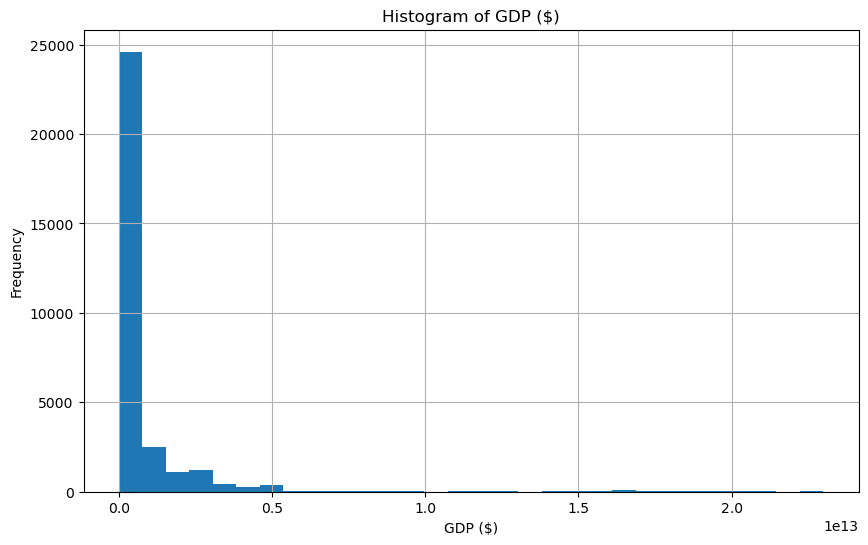

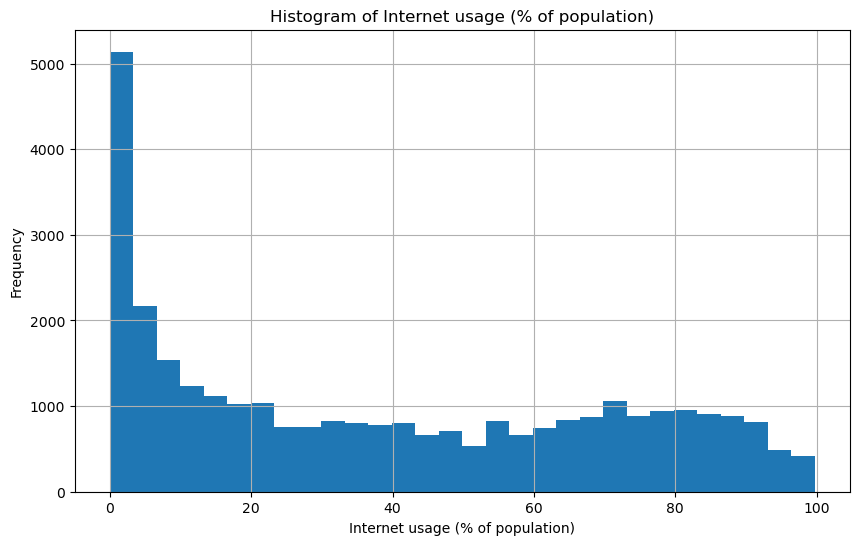

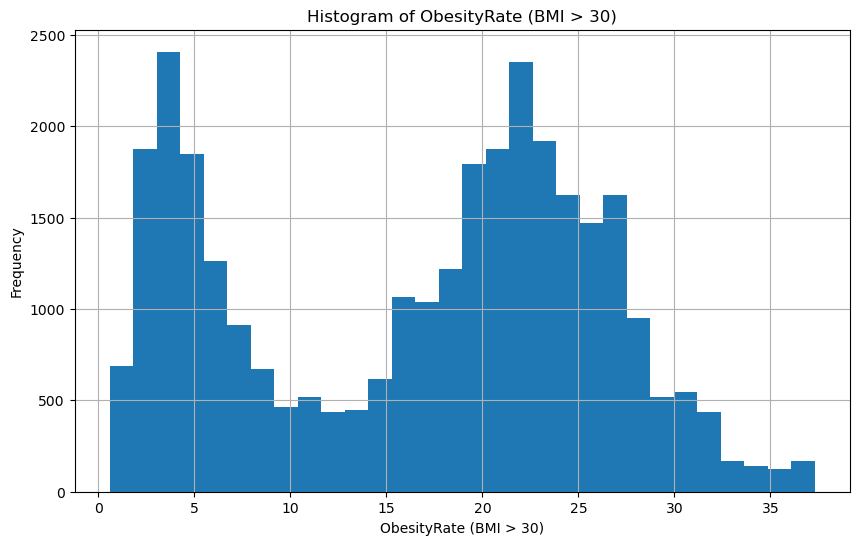

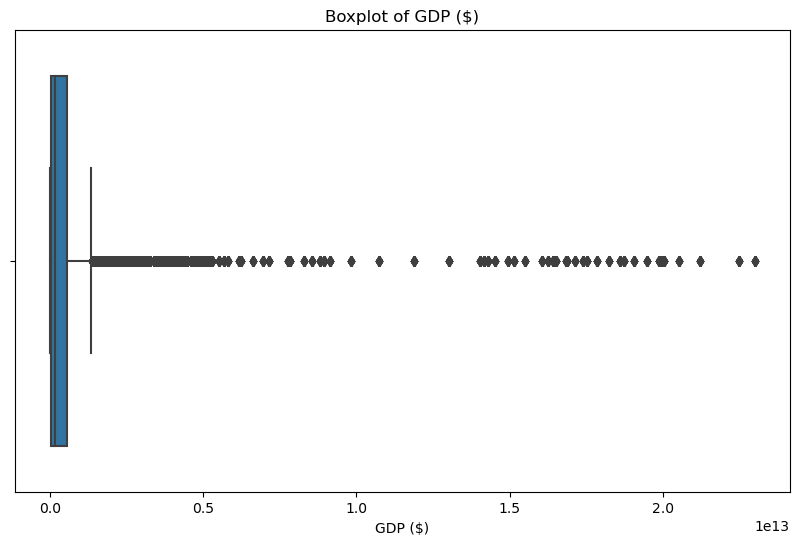

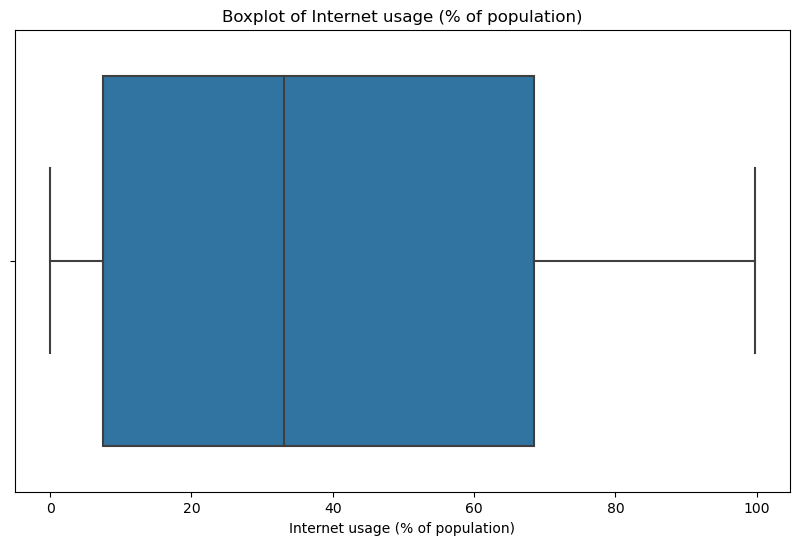

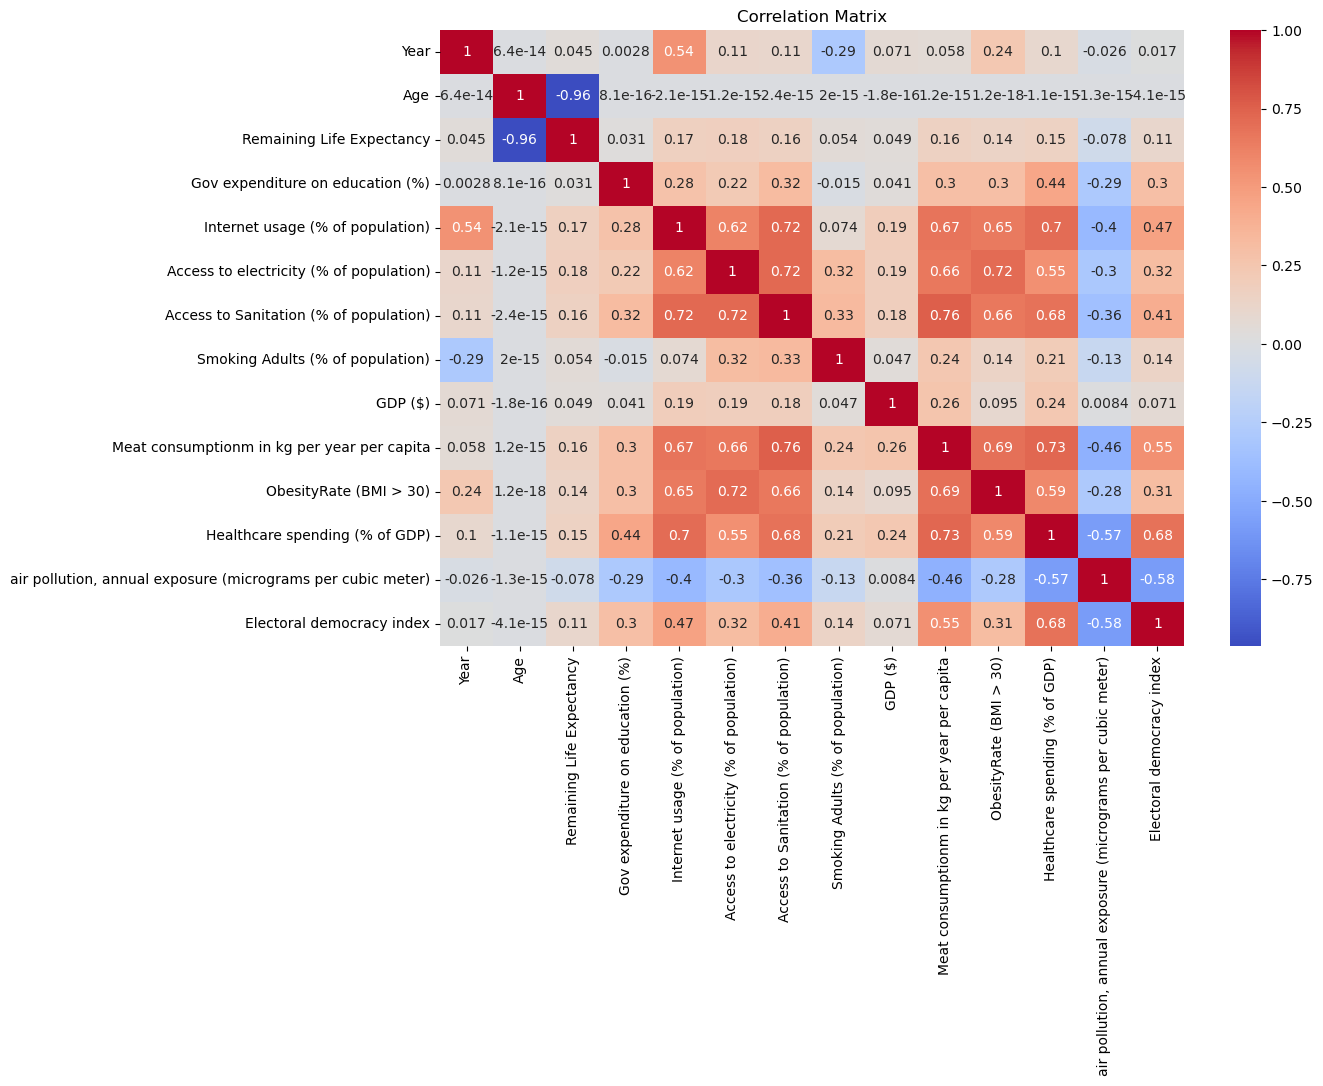

In [216]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
# Load the final merged dataset
final_df = pd.read_csv('final_merged_data.csv')
 
# Display basic descriptive statistics
print("Descriptive Statistics:")
print(final_df.describe())
 
# Histograms for selected columns
columns_to_visualize = ['GDP ($)', 'Internet usage (% of population)', 'ObesityRate (BMI > 30)']
for column in columns_to_visualize:
    plt.figure(figsize=(10, 6))
    final_df[column].hist(bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
 
# Boxplots for potential outlier detection in specific columns
columns_for_outliers = ['GDP ($)', 'Internet usage (% of population)']
for column in columns_for_outliers:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=final_df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()
 
# Correlation matrix (optional)
plt.figure(figsize=(12, 8))
# Update here: specify numeric_only=True
sns.heatmap(final_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Feature Selection & Engineering

Korrelationen und welches sind wichtige features
binary encoding for categorial variables

In [217]:
# List of countries to be removed
countries_to_remove = [
    'United Arab Emirates', 'Cayman Islands', 'Suriname', 'Curacao', 'Turkmenistan',
    'South Sudan', 'Uzbekistan', 'Palestine', 'East Timor', 'Liberia', 'Vietnam', 'Nauru',
    'Serbia', 'American Samoa', 'Bahrain', 'Kosovo', 'Curacao', 'South Sudan', 'North Korea',
    'Liberia', 'South Sudan', 'Turks and Caicos Islands', 'Greenland', 'Channel Islands',
    'Montenegro', 'Djibouti', 'Somalia', 'Turks and Caicos Islands', 'Sint Maarten (Dutch part)',
    'Kosovo', 'Cayman Islands', 'Bahrain', 'Bhutan', 'Micronesia (country)', 'Nauru', 'Qatar',
    'South Sudan', 'Burundi', 'Sudan', 'Comoros', 'Democratic Republic of Congo', 'Libya',
    'Papua New Guinea', 'Seychelles', 'Syria', 'Montenegro', 'Serbia', 'South Sudan',
    'Montenegro', 'Zimbabwe'
]

# Remove rows with the specified countries
final_df = final_df[~final_df['Entity'].isin(countries_to_remove)]

final_df


,Entity,Code,Year,Sex,Age,Remaining Life Expectancy,Gov expenditure on education (%),Internet usage (% of population),Access to electricity (% of population),Access to Sanitation (% of population),Smoking Adults (% of population),GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
0,Algeria,DZA,2000,Female,0,71.9487,4.982849,0.491706,98.97310,58.85,22.200000,2.703917e+11,18.933718,15.0,2.510828,37.536050,0.326
1,Algeria,DZA,2001,Female,0,72.1968,4.902120,0.646114,98.96687,59.19,22.120000,2.785034e+11,17.341906,15.5,2.925499,37.200605,0.326
2,Algeria,DZA,2002,Female,0,72.5595,4.821391,1.591641,98.95306,59.53,22.040000,2.940996e+11,18.096855,16.1,2.807926,36.865160,0.329
3,Algeria,DZA,2003,Female,0,72.2499,4.740663,2.195360,98.93401,59.86,21.960000,3.152748e+11,19.324575,16.7,2.761790,36.529716,0.335
4,Algeria,DZA,2004,Female,0,72.8122,4.659934,4.634475,98.91208,60.18,21.880000,3.288316e+11,21.336285,17.3,2.528820,36.194271,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31096,United States,USA,2016,Male,80,8.7799,4.806660,85.544420,100.00000,97.19,24.666667,1.905248e+13,118.195300,37.3,8.557327,7.406464,0.884
31097,United States,USA,2017,Male,80,8.7725,5.122880,87.274890,100.00000,97.16,24.033333,1.947962e+13,119.273290,37.3,8.512190,7.409441,0.820
31098,United States,USA,2018,Male,80,8.8969,4.928890,88.498900,100.00000,97.14,23.400000,2.005337e+13,123.623640,37.3,8.472342,7.409441,0.813
31099,United States,USA,2019,Male,80,9.0346,4.987280,89.430280,100.00000,97.11,23.400000,2.051348e+13,126.303100,37.3,8.524923,7.409441,0.800


#### Binary encoding

In [218]:

final_df2 = final_df.drop('Code', axis=1)
 
# Selected columns for binary encoding
columns_to_encode = ['Sex', 'Entity']
 
# Create a new DataFrame for training with binary encoding
encoder = ce.BinaryEncoder(cols=columns_to_encode, drop_invariant=True, return_df=True)

training_dataset = encoder.fit_transform(final_df2)
 
# Save the original column names before encoding
original_columns = encoder.get_feature_names_out()
 
# Save the result

training_dataset.to_csv('training_dataset_binary.csv', index=False)
 
# Back-encode to get the original DataFrame
original_df = encoder.inverse_transform(training_dataset[original_columns])
 
training_dataset

,Entity_0,Entity_1,Entity_2,Entity_3,Entity_4,Entity_5,Entity_6,Year,Sex_0,Sex_1,...,Internet usage (% of population),Access to electricity (% of population),Access to Sanitation (% of population),Smoking Adults (% of population),GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
0,0,0,0,0,0,0,1,2000,0,1,...,0.491706,98.97310,58.85,22.200000,2.703917e+11,18.933718,15.0,2.510828,37.536050,0.326
1,0,0,0,0,0,0,1,2001,0,1,...,0.646114,98.96687,59.19,22.120000,2.785034e+11,17.341906,15.5,2.925499,37.200605,0.326
2,0,0,0,0,0,0,1,2002,0,1,...,1.591641,98.95306,59.53,22.040000,2.940996e+11,18.096855,16.1,2.807926,36.865160,0.329
3,0,0,0,0,0,0,1,2003,0,1,...,2.195360,98.93401,59.86,21.960000,3.152748e+11,19.324575,16.7,2.761790,36.529716,0.335
4,0,0,0,0,0,0,1,2004,0,1,...,4.634475,98.91208,60.18,21.880000,3.288316e+11,21.336285,17.3,2.528820,36.194271,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31096,1,1,0,0,0,1,1,2016,1,0,...,85.544420,100.00000,97.19,24.666667,1.905248e+13,118.195300,37.3,8.557327,7.406464,0.884
31097,1,1,0,0,0,1,1,2017,1,0,...,87.274890,100.00000,97.16,24.033333,1.947962e+13,119.273290,37.3,8.512190,7.409441,0.820
31098,1,1,0,0,0,1,1,2018,1,0,...,88.498900,100.00000,97.14,23.400000,2.005337e+13,123.623640,37.3,8.472342,7.409441,0.813
31099,1,1,0,0,0,1,1,2019,1,0,...,89.430280,100.00000,97.11,23.400000,2.051348e+13,126.303100,37.3,8.524923,7.409441,0.800


#### onehot encoding

In [219]:
final_df2 = final_df.drop('Code', axis=1)

# Selected columns for one-hot encoding
columns_to_encode = ['Sex', 'Entity']

# Create a new DataFrame for training with one-hot encoding
encoder = ce.OneHotEncoder(cols=columns_to_encode, use_cat_names=True)

training_dataset_onehot = encoder.fit_transform(final_df2)

# Save the result as CSV
training_dataset_onehot.to_csv('training_dataset_onehot.csv', index=False)

training_dataset_onehot

,Entity_Algeria,Entity_Argentina,Entity_Armenia,Entity_Australia,Entity_Austria,Entity_Azerbaijan,Entity_Bangladesh,Entity_Belarus,Entity_Belgium,Entity_Benin,...,Internet usage (% of population),Access to electricity (% of population),Access to Sanitation (% of population),Smoking Adults (% of population),GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
0,1,0,0,0,0,0,0,0,0,0,...,0.491706,98.97310,58.85,22.200000,2.703917e+11,18.933718,15.0,2.510828,37.536050,0.326
1,1,0,0,0,0,0,0,0,0,0,...,0.646114,98.96687,59.19,22.120000,2.785034e+11,17.341906,15.5,2.925499,37.200605,0.326
2,1,0,0,0,0,0,0,0,0,0,...,1.591641,98.95306,59.53,22.040000,2.940996e+11,18.096855,16.1,2.807926,36.865160,0.329
3,1,0,0,0,0,0,0,0,0,0,...,2.195360,98.93401,59.86,21.960000,3.152748e+11,19.324575,16.7,2.761790,36.529716,0.335
4,1,0,0,0,0,0,0,0,0,0,...,4.634475,98.91208,60.18,21.880000,3.288316e+11,21.336285,17.3,2.528820,36.194271,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31096,0,0,0,0,0,0,0,0,0,0,...,85.544420,100.00000,97.19,24.666667,1.905248e+13,118.195300,37.3,8.557327,7.406464,0.884
31097,0,0,0,0,0,0,0,0,0,0,...,87.274890,100.00000,97.16,24.033333,1.947962e+13,119.273290,37.3,8.512190,7.409441,0.820
31098,0,0,0,0,0,0,0,0,0,0,...,88.498900,100.00000,97.14,23.400000,2.005337e+13,123.623640,37.3,8.472342,7.409441,0.813
31099,0,0,0,0,0,0,0,0,0,0,...,89.430280,100.00000,97.11,23.400000,2.051348e+13,126.303100,37.3,8.524923,7.409441,0.800


### List the encodings

In [220]:
# Extract binary encoded 'Entity' columns
binary_encoded_entities = training_dataset.filter(regex='^Entity_')

# Retrieve the original 'Entity' values from the back-encoded DataFrame
original_entities = original_df['Entity']

# Create a DataFrame that pairs each original 'Entity' with its binary encoding
entity_binary_encoding = pd.concat([original_entities, binary_encoded_entities], axis=1).drop_duplicates()

# Convert the DataFrame to a list of tuples for easier reading
entity_binary_encoding_list = list(entity_binary_encoding.itertuples(index=False, name=None))

# Print the list to see the original 'Entity' and their binary encodings
for item in entity_binary_encoding_list:
    print(item)




('Algeria', 0, 0, 0, 0, 0, 0, 1)
('Argentina', 0, 0, 0, 0, 0, 1, 0)
('Armenia', 0, 0, 0, 0, 0, 1, 1)
('Australia', 0, 0, 0, 0, 1, 0, 0)
('Austria', 0, 0, 0, 0, 1, 0, 1)
('Azerbaijan', 0, 0, 0, 0, 1, 1, 0)
('Bangladesh', 0, 0, 0, 0, 1, 1, 1)
('Belarus', 0, 0, 0, 1, 0, 0, 0)
('Belgium', 0, 0, 0, 1, 0, 0, 1)
('Benin', 0, 0, 0, 1, 0, 1, 0)
('Brazil', 0, 0, 0, 1, 0, 1, 1)
('Bulgaria', 0, 0, 0, 1, 1, 0, 0)
('Burkina Faso', 0, 0, 0, 1, 1, 0, 1)
('Cambodia', 0, 0, 0, 1, 1, 1, 0)
('Canada', 0, 0, 0, 1, 1, 1, 1)
('Chad', 0, 0, 1, 0, 0, 0, 0)
('Chile', 0, 0, 1, 0, 0, 0, 1)
('China', 0, 0, 1, 0, 0, 1, 0)
('Colombia', 0, 0, 1, 0, 0, 1, 1)
('Costa Rica', 0, 0, 1, 0, 1, 0, 0)
("Cote d'Ivoire", 0, 0, 1, 0, 1, 0, 1)
('Croatia', 0, 0, 1, 0, 1, 1, 0)
('Cyprus', 0, 0, 1, 0, 1, 1, 1)
('Czechia', 0, 0, 1, 1, 0, 0, 0)
('Denmark', 0, 0, 1, 1, 0, 0, 1)
('Dominican Republic', 0, 0, 1, 1, 0, 1, 0)
('Ecuador', 0, 0, 1, 1, 0, 1, 1)
('Egypt', 0, 0, 1, 1, 1, 0, 0)
('Estonia', 0, 0, 1, 1, 1, 0, 1)
('Ethiopia', 0, 0, 

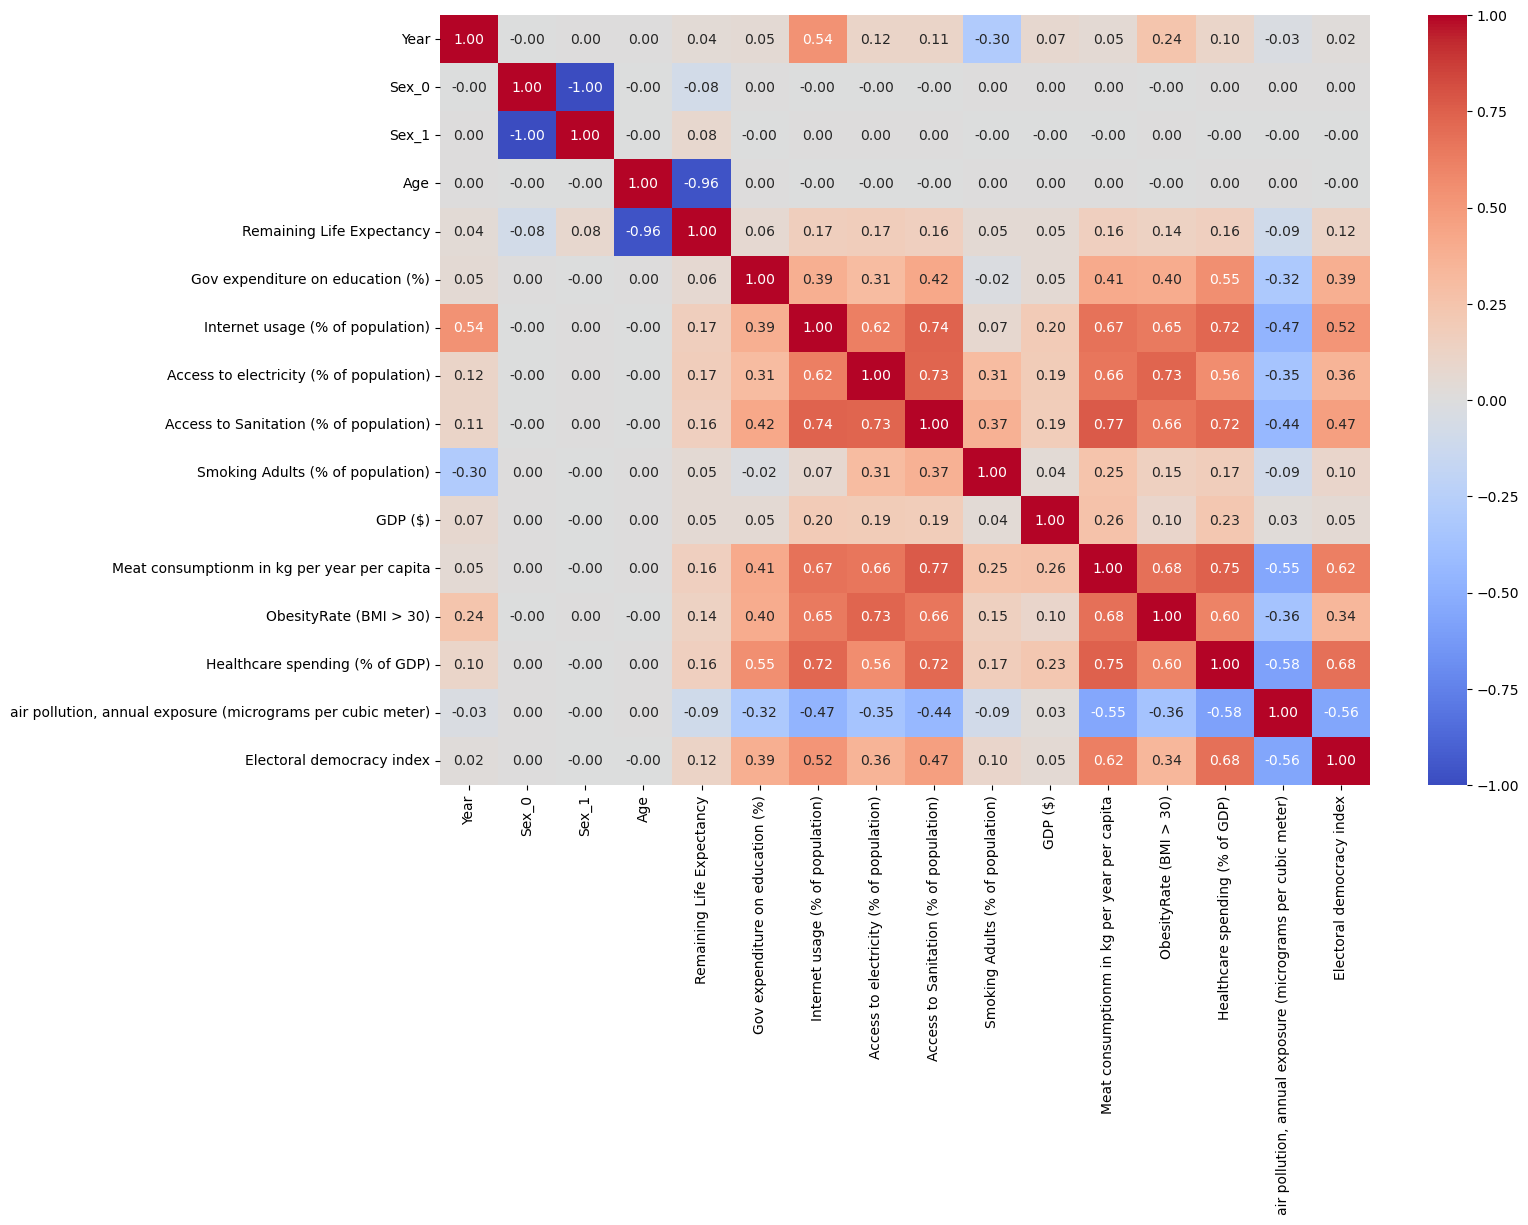

In [221]:
# Exclude columns 'Entity_0' to 'Entity_6' from the correlation matrix
columns_to_exclude = [f'Entity_{i}' for i in range(7)]  # Assuming you have 'Entity_0' to 'Entity_6'
correlation_matrix = training_dataset.drop(columns=columns_to_exclude).corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Show the plot
plt.show()
#    0 to 0.2: Very weak correlation
#    0.2 to 0.4: Weak correlation
#    0.4 to 0.6: Moderate correlation
#    0.6 to 0.8: Strong correlation
#    0.8 to 1.0: Very strong correlation

# Anwendung in Machine Learning

##### Linear regression

In [222]:
data = pd.read_csv('training_dataset_binary.csv')

#Remaining Life Expectancy target variable
X = data.drop('Remaining Life Expectancy', axis=1)
y = data['Remaining Life Expectancy']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Model Performance: RMSE = {rmse}")

# Save model
dump(model, 'frontend/linreg.joblib')

Model Performance: RMSE = 3.7843048534770007


['frontend/linreg.joblib']

#### Random Forest 

In [223]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
 
# Laden der Daten
data = pd.read_csv('training_dataset_binary.csv')
 
# Zielvariable ist "Remaining Life Expectancy"
X = data.drop('Remaining Life Expectancy', axis=1)
y = data['Remaining Life Expectancy']
 
# Aufteilung der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
# Initialisierung und Training des Random Forest Regressors
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
 
# Vorhersagen und Auswertung des Modells
y_pred = rf_model.predict(X_test)
 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
 
print(f"Model Performance:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")
 
 
# Feature Importance
feature_importance = rf_model.feature_importances_
 
# Verknüpfen der Feature-Wichtigkeiten mit den entsprechenden Feature-Namen
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
 
# Ausgabe der wichtigsten Features
print("Feature Importance:")
print(feature_importance_df.round(5))

Model Performance:
Mean Squared Error (MSE): 0.44729324358144995
Root Mean Squared Error (RMSE): 0.6687998531559722
Mean Absolute Error (MAE): 0.402413476296806
R-squared (R2): 0.9992023186046252
Feature Importance:
                                              Feature  Importance
10                                                Age     0.93227
13            Access to electricity (% of population)     0.03924
21                          Electoral democracy index     0.00525
8                                               Sex_0     0.00439
9                                               Sex_1     0.00410
19                     Healthcare spending (% of GDP)     0.00307
15                   Smoking Adults (% of population)     0.00185
12                   Internet usage (% of population)     0.00160
16                                            GDP ($)     0.00147
14             Access to Sanitation (% of population)     0.00143
18                             ObesityRate (BMI > 30)     

#### XGBoost

In [224]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# Load the binary-encoded dataset
data_binary = pd.read_csv('training_dataset_binary.csv')
 
# Separate the features and the target variable
X_binary = data_binary.drop('Remaining Life Expectancy', axis=1)
y_binary = data_binary['Remaining Life Expectancy']
 
# Split the dataset into training and test sets
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)
 
# Initialize the XGBoost regressor
model_binary = xgb.XGBRegressor(objective='reg:squarederror')
 
# Train the model
model_binary.fit(X_train_binary, y_train_binary)
 
# Predict and evaluate the model
predictions_binary = model_binary.predict(X_test_binary)
mse_binary = mean_squared_error(y_test_binary, predictions_binary)
 
# Calculate RMSE
rmse_binary = np.sqrt(mse_binary)
print(f'Root Mean Squared Error for binary-encoded dataset: {rmse_binary}')

Root Mean Squared Error for binary-encoded dataset: 0.6698129231260048


In [225]:
# Load the one-hot-encoded dataset
data_onehot = pd.read_csv('training_dataset_onehot.csv')
 
# Separate the features and the target variable
X_onehot = data_onehot.drop('Remaining Life Expectancy', axis=1)
y_onehot = data_onehot['Remaining Life Expectancy']
 
# Split the dataset into training and test sets
X_train_onehot, X_test_onehot, y_train_onehot, y_test_onehot = train_test_split(X_onehot, y_onehot, test_size=0.2, random_state=42)
 
# Initialize the XGBoost regressor
model_onehot = xgb.XGBRegressor(objective='reg:squarederror')
 
# Train the model
model_onehot.fit(X_train_onehot, y_train_onehot)
 
# Predict and evaluate the model
predictions_onehot = model_onehot.predict(X_test_onehot)
mse_onehot = mean_squared_error(y_test_onehot, predictions_onehot)
 
# Calculate RMSE
rmse_onehot = np.sqrt(mse_onehot)
print(f'Root Mean Squared Error for binary-encoded dataset: {rmse_onehot}')

Root Mean Squared Error for binary-encoded dataset: 0.7218487228488684


In [226]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
 
# Load the dataset
data = pd.read_csv('training_dataset_binary.csv')  
 
# Separate the features and the target variable
X = data.drop('Remaining Life Expectancy', axis=1).values
y = data['Remaining Life Expectancy'].values
 
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
 
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
 
# Create PyTorch datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
 
# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
 
# Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
 
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
 
# Model, Loss, and Optimizer
model = NeuralNet(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
# Training the Model
num_epochs = 20
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
 
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
 
# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        total += targets.size(0)
        correct += (outputs.squeeze() - targets).abs().sum().item()
 
print('Mean Absolute Error on test set:', correct / total)

Epoch [1/20], Step [100/364], Loss: 1231.6979
Epoch [1/20], Step [200/364], Loss: 205.9994
Epoch [1/20], Step [300/364], Loss: 83.9517
Epoch [2/20], Step [100/364], Loss: 14.9959
Epoch [2/20], Step [200/364], Loss: 14.1022
Epoch [2/20], Step [300/364], Loss: 9.5004
Epoch [3/20], Step [100/364], Loss: 8.2140
Epoch [3/20], Step [200/364], Loss: 5.6281
Epoch [3/20], Step [300/364], Loss: 6.9013
Epoch [4/20], Step [100/364], Loss: 5.3183
Epoch [4/20], Step [200/364], Loss: 5.8989
Epoch [4/20], Step [300/364], Loss: 6.2667
Epoch [5/20], Step [100/364], Loss: 4.1076
Epoch [5/20], Step [200/364], Loss: 4.2638
Epoch [5/20], Step [300/364], Loss: 2.5313
Epoch [6/20], Step [100/364], Loss: 2.8280
Epoch [6/20], Step [200/364], Loss: 2.7046
Epoch [6/20], Step [300/364], Loss: 2.5070
Epoch [7/20], Step [100/364], Loss: 2.3668
Epoch [7/20], Step [200/364], Loss: 4.1422
Epoch [7/20], Step [300/364], Loss: 2.6631
Epoch [8/20], Step [100/364], Loss: 2.1296
Epoch [8/20], Step [200/364], Loss: 1.8968
Epo

##### Linear regression SGD (Binary)

In [227]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

# Load the dataset (binary encoding)
data_binary = pd.read_csv('training_dataset_binary.csv')

# Splitting the data into features and target variable
X_binary = data_binary.drop(data_binary.columns[-1], axis=1)
y_binary = data_binary.iloc[:, -1]

# Splitting the data into training and testing sets
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)

# Standardizing the features
scaler_binary = StandardScaler()
X_train_scaled_binary = scaler_binary.fit_transform(X_train_binary)
X_test_scaled_binary = scaler_binary.transform(X_test_binary)

# Creating and training the SGD Regressor
sgd_reg_binary = SGDRegressor(random_state=42)
sgd_reg_binary.fit(X_train_scaled_binary, y_train_binary)

# Predictions
y_pred_sgd_binary = sgd_reg_binary.predict(X_test_scaled_binary)

# Evaluation
mse_sgd_binary = mean_squared_error(y_test_binary, y_pred_sgd_binary)
rmse_sgd_binary = np.sqrt(mse_sgd_binary)

print(f"SGD Regressor Performance on Binary Encoded Data: RMSE = {rmse_sgd_binary}")

# Save the SGD model (binary encoding)
dump(sgd_reg_binary, 'frontend/sgd_reg_binary.joblib')

SGD Regressor Performance on Binary Encoded Data: RMSE = 0.16052448955016455


['frontend/sgd_reg_binary.joblib']

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


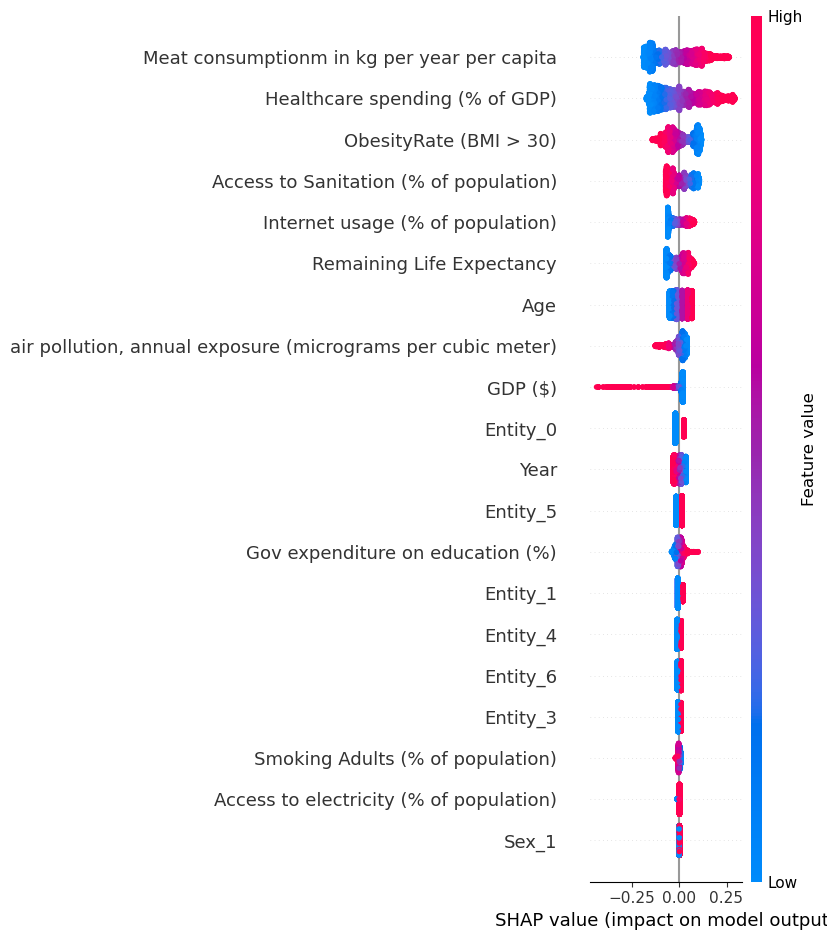

In [228]:
import shap

# Erstellen eines SHAP-Explainers für das Modell
explainer_binary = shap.Explainer(sgd_reg_binary, X_train_scaled_binary)

# Berechnung der SHAP-Werte für die Testdaten
shap_values_binary = explainer_binary(X_test_scaled_binary)

# Visualisierung der SHAP-Werte (zum Beispiel mit einem Summary Plot)
shap.summary_plot(shap_values_binary, X_test_scaled_binary, feature_names=X_binary.columns)

##### Linear regression SGD (One Hot)

In [229]:
# Load the dataset (one-hot encoding)
data_onehot = pd.read_csv('training_dataset_onehot.csv')

# Splitting the data into features and target variable
X_onehot = data_onehot.drop(data_onehot.columns[-1], axis=1)
y_onehot = data_onehot.iloc[:, -1]

# Splitting the data into training and testing sets
X_train_onehot, X_test_onehot, y_train_onehot, y_test_onehot = train_test_split(X_onehot, y_onehot, test_size=0.2, random_state=42)

# Standardizing the features
scaler_onehot = StandardScaler()
X_train_scaled_onehot = scaler_onehot.fit_transform(X_train_onehot)
X_test_scaled_onehot = scaler_onehot.transform(X_test_onehot)

# Creating and training the SGD Regressor
sgd_reg_onehot = SGDRegressor(random_state=42)
sgd_reg_onehot.fit(X_train_scaled_onehot, y_train_onehot)

# Predictions
y_pred_sgd_onehot = sgd_reg_onehot.predict(X_test_scaled_onehot)

# Evaluation
mse_sgd_onehot = mean_squared_error(y_test_onehot, y_pred_sgd_onehot)
rmse_sgd_onehot = np.sqrt(mse_sgd_onehot)

print(f"SGD Regressor Performance on One-Hot Encoded Data: RMSE = {rmse_sgd_onehot}")

# Save the SGD model (one-hot encoding)
dump(sgd_reg_onehot, 'frontend/sgd_reg_onehot.joblib')


SGD Regressor Performance on One-Hot Encoded Data: RMSE = 0.06562625586679674


['frontend/sgd_reg_onehot.joblib']

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


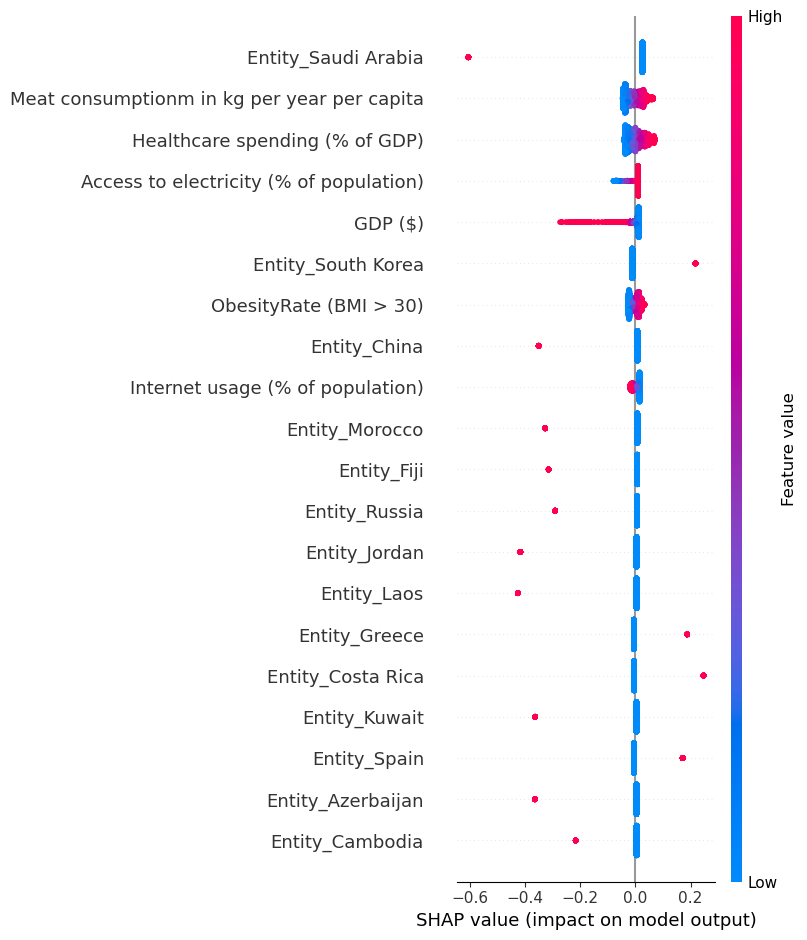

In [230]:
# Erstellen eines SHAP-Explainers für das Modell
explainer_onehot = shap.Explainer(sgd_reg_onehot, X_train_scaled_onehot)

# Berechnung der SHAP-Werte für die Testdaten
shap_values_onehot = explainer_onehot(X_test_scaled_onehot)

# Visualisierung der SHAP-Werte (zum Beispiel mit einem Summary Plot)
shap.summary_plot(shap_values_onehot, X_test_scaled_onehot, feature_names=X_onehot.columns)

#### Cross Validation

In [231]:
array = df.values
X = array[:,1:30]
Y = array[:,0]
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression(max_iter=1000, solver='liblinear')))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier(max_depth=9)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=15)))
models.append(('RF', RandomForestClassifier(max_depth = 3, max_leaf_nodes = 3, n_estimators = 3, random_state = 42)))
models.append(('SVM', svm.SVC()))
models.append(('NN', MLPClassifier(hidden_layer_sizes = 17, activation = 'relu', random_state = 42)))
models.append(('XGB', XGBClassifier(random_state=42,gpu_id=0)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

NameError: name 'LogisticRegression' is not defined

# Anwendung von XAI – Techniken

In [ ]:
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

                                                     Coefficient
Entity_0                                           -2.354815e-01
Entity_1                                           -9.719235e-02
Entity_2                                            3.308036e-01
Entity_3                                            6.069334e-01
Entity_4                                           -1.955343e-01
Entity_5                                            4.621289e-01
Entity_6                                           -3.514307e-01
Year                                               -2.269118e-02
Sex_0                                              -2.012349e+00
Sex_1                                               2.012349e+00
Age                                                -8.279875e-01
Gov expenditure on education (%)                   -4.490555e-01
Internet usage (% of population)                    5.341702e-02
Access to electricity (% of population)             9.097550e-02
Access to Sanitation (% o

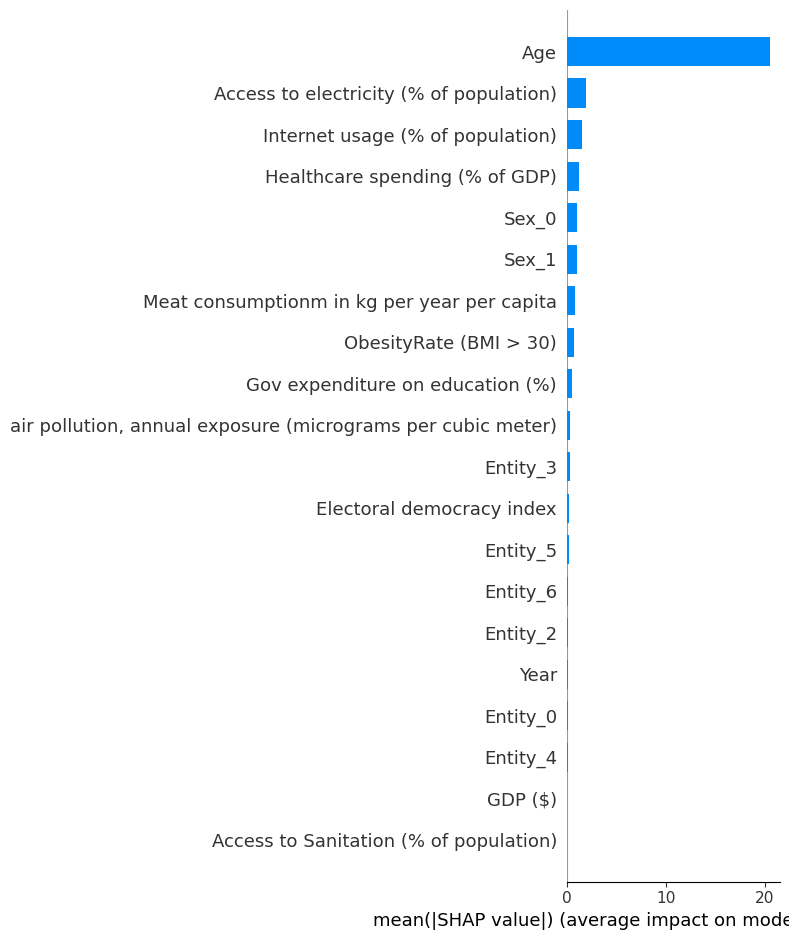

In [ ]:
import shap
 
# SHAP-Werte berechnen
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)
 
# SHAP-Zusammenfassungsplot
shap.summary_plot(shap_values, X_test, plot_type="bar")
 
# SHAP-Werte für einen spezifischen Datenpunkt
shap.initjs()
i = 20  # Index des Datenpunkts
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])

# Applikation